# Goal: Answer the following questions
### Which countries offer the longest races?
### Which races take the longest to finish on average?

In [1]:
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
from pathlib import Path

/Users/ds/Coding/Python/Data-Analyst/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = kagglehub.dataset_download("aiaiaidavid/the-big-dataset-of-ultra-marathon-running")

print("Path to dataset files:", file_path)

Path to dataset files: /Users/ds/.cache/kagglehub/datasets/aiaiaidavid/the-big-dataset-of-ultra-marathon-running/versions/2


In [3]:
df = pd.read_csv(Path(file_path, "TWO_CENTURIES_OF_UM_RACES.csv"))
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.sample(5)

/var/folders/_w/p__mh4fn0pj6hdp6rksxkw9r0000gn/T/ipykernel_86509/679266690.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(file_path, "TWO_CENTURIES_OF_UM_RACES.csv"))


,Year of event,Event dates,Event name,Event distance/length,Event number of finishers,Athlete performance,Athlete club,Athlete country,Athlete year of birth,Athlete gender,Athlete age category,Athlete average speed,Athlete ID
2907211,2021,08.-10.07.2021,Ultra-Trail Di Corsica (FRA),110km,123,27:10:35 h,Team Edf-Cmcas / Bike ...,FRA,1989.0,M,M23,4.048,242760
425616,2018,09.09.2018,Trail des légendes de Brocéliande (FRA),50km,318,4:35:47 h,Team Trail du Bocage,FRA,1980.0,M,M35,10.878,49247
1324632,2017,11.03.2017,6-Stunden-Lauf Münster - DUV-DM (GER),6h,533,51.003 km,Marathon Steinfurt,GER,1953.0,M,M60,8.501,375641
2457309,2019,28.-29.09.2019,Les 100 km de Millau (FRA),100km,1008,12:02:17 h,Coureurs du Monde EN I...,FRA,1971.0,F,W45,8.307,791101
1207270,2017,11.02.2017,Golden Gate 50 km Winter Trail Run (USA),50km,45,6:50:08 h,"*San Francisco, CA",USA,1979.0,M,M35,7.315,468726


In [4]:
df.dtypes

Year of event                  int64
Event dates                   object
Event name                    object
Event distance/length         object
Event number of finishers      int64
Athlete performance           object
Athlete club                  object
Athlete country               object
Athlete year of birth        float64
Athlete gender                object
Athlete age category          object
Athlete average speed         object
Athlete ID                     int64
dtype: object

## Data Cleaning

#### Standardizing 'Event distance/length' column

In [5]:
# Find unique valies for 'Event distance/length'
unique_distances = df['Event distance/length'].unique()
pd.Series(unique_distances).sample(10)

1494             83.1km
1075             65.4km
129                89km
1095            106.6km
1353             30.7mi
668              64.2km
871              77.9km
1392    705km/12Etappen
47       150km/3Etappen
128              49.7km
dtype: object

In [6]:
# find unique 2-digit suffixes for distance
suffixes = df['Event distance/length'].str.split('/').str.get(0).str[-2:]
suffixes.unique().shape # -> 29

(29,)

In [7]:
# Filter out races where distance isn't recorded in miles ('mi') or kilometers ('km')
df = df[df['Event distance/length'].str.endswith(("mi", "km"))].reset_index()
df.shape

(4059693, 14)

In [8]:
# Filtering out distances that can't be converted to a number
before_row_count = df.shape[0]
df = df[~pd.to_numeric(df['Event distance/length'].str[:-2], errors='coerce').isna()]
print(before_row_count - df.shape[0], "rows filtered out") # -> 25

25 rows filtered out


In [9]:
# creating new column that standardizes event distances to miles
condition = df['Event distance/length'].str.endswith("km")

df['Event distance (miles)'] = np.where(
        condition,
        pd.to_numeric(df['Event distance/length'].str[:-2]) * 0.621371, 
        pd.to_numeric(df['Event distance/length'].str[:-2])
    ).round(2)

df = df[['Event name', 'Year of event', 'Event distance/length', 'Event distance (miles)']]
df.sample(10)

,Event name,Year of event,Event distance/length,Event distance (miles)
3091233,Okinoshima 50km Ultra Marathon (JPN),2013,50km,31.07
3751001,100 km Lauf Biel (SUI),1975,100km,62.14
1467631,Full mOOn Run - Midnight 50K (USA),2021,50km,31.07
3756764,100 km Lauf Biel (SUI),1976,100km,62.14
495105,Trail de Guerlédan (FRA),2016,58km,36.04
2217814,"Laugavegurinn 55 km, Landmannalaugar - Húsadal...",2005,55km,34.18
2238411,GutsMuths-Rennsteiglauf (GER),2005,72.7km,45.17
174657,Lakeland 50 Mile (GBR),2018,50mi,50.00
429628,Ultrabericus Trail (ITA),2016,66km,41.01
2148543,Mountain Masochist 50 Mile Trail Run (USA),2004,50mi,50.00


In [10]:
# get country code from 'Event name' field
df['code'] = df['Event name'].str[-4:-1]
df.sample(10)

,Event name,Year of event,Event distance/length,Event distance (miles),code
3563990,Run for Kids 50 km Challenge (USA),2015,50km,31.07,USA
2155060,Subida al Pico Veleta (ESP),2004,50km,31.07,ESP
1645305,Trail des 2 Amants - Maxi'TDA (FRA),2022,85km,52.82,FRA
48630,The Canyons Endurance 100 Km Run (USA),2018,100km,62.14,USA
1182211,La 6000D (FRA),2019,65.5km,40.70,FRA
2469913,Comrades Marathon - Up Run (RSA),2008,87km,54.06,RSA
1722244,Tahoe 200 Mile Endurance Run (USA),2022,202mi,202.00,USA
1800211,Nice Côte d'Azur by UTMB - 50K (FRA),2022,59km,36.66,FRA
1404271,MuleSkinner Endurance 50 km Race (USA),2020,50km,31.07,USA
3385617,SkyView Ultra-Trail 60 - Yamada Noboru Memoria...,2014,66km,41.01,JPN


In [11]:
# map country code to country name
import pycountry

results = []
for country in pycountry.countries:
    results.append([country.name, country.alpha_3])

country_df = pd.DataFrame(results, columns=['country', 'code'])

df = pd.merge(df, country_df, on='code', how='left')
df[df['code'].isna()].shape[0] # -> 0 rows left unmapped

0

## Which countries offer the longest races?

In [12]:
long_races_df = df.groupby('country')['Event distance (miles)'].agg(['mean', 'max'])
long_races_df = long_races_df.sort_values(by='max', ascending=False).head(10)

### Findings, according to our dataset:
- The United States offers the longest ultramarathon at 3085 miles
- 9 countries offer ultramarathons that are 500 miles or more

<Axes: ylabel='max'>

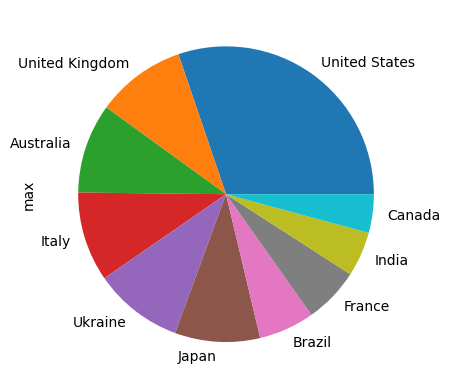

In [13]:
long_races_df['max'].plot(kind='pie')